In [1]:
from PIL import Image
import numpy as np
from numpy.ma import array
from scipy import ndimage
import cv2
import glob
from matplotlib import pyplot as plt
import time

In [2]:
# Specify the path of dataset folder here
dataset_path = "./dataset"

# Get paths of all images
left_images = np.sort(glob.glob(f"{dataset_path}/*left.jpg"))
right_images = np.sort(glob.glob(f"{dataset_path}/*right.jpg"))
ground_truths = np.sort(glob.glob(f"{dataset_path}/*disparity.png"))

# Different methods of computing disparity map
M1 = "ncc_uniform"
M2 = "ncc_gaussian"
M3 = "ssd_uniform"
M4 = "ssd_gaussian"

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Matching function: NCC
# Uniform filter: all pixels in the matching window are equally important
def dmap_ncc_uniform(path_l, path_r, d_range, window_size):
    # Read images and get shape
    img_l = array(cv2.imread(path_l,cv2.IMREAD_GRAYSCALE), 'f')
    img_r = array(cv2.imread(path_r,cv2.IMREAD_GRAYSCALE), 'f')
    x, y = img_l.shape

    # Init arrays for calculating ncc
    mean_l = np.zeros((x, y))
    mean_r = np.zeros((x, y))
    s = np.zeros((x, y))
    sum_l = np.zeros((x, y))
    sum_r = np.zeros((x, y))
    
    # Init array for storing disparity values
    d_map = np.zeros((x, y, d_range))

    # Get mean value of image pixels
    ndimage.uniform_filter(img_l, window_size, mean_l)
    ndimage.uniform_filter(img_r, window_size, mean_r)

    # Normalise images
    norm_l = img_l - mean_l
    norm_r = img_r - mean_r
    
    # Try different disparity values
    for d_value in range(d_range):
        # Shift the left image to the right and calculate ncc
        shift_l = np.roll(norm_l, -d_value, 0)
        ndimage.uniform_filter(shift_l * norm_r, window_size, s)
        ndimage.uniform_filter(shift_l *  shift_l, window_size, sum_l)
        ndimage.uniform_filter(norm_r * norm_r, window_size, sum_r)
        d_map[:,:,d_value] = s / np.sqrt(abs(sum_l * sum_r))
    # Pick the optimal diparity value for each pixel
    return np.argmax(d_map, axis=2)

In [4]:
# Matching function: NCC
# Gaussian filter: pixels' importance follows gaussian distribution
def dmap_ncc_gaussian(path_l, path_r, d_range, window_size, upscale=1):
    
    # Read images and get shape
    img_l = cv2.imread(path_l,cv2.IMREAD_GRAYSCALE)
    img_r = cv2.imread(path_r,cv2.IMREAD_GRAYSCALE)

    if upscale > 1:
        img_l = cv2.resize(img_l, (img_l.shape[1] * upscale, img_l.shape[0] * upscale), interpolation = cv2.INTER_LINEAR)
        img_r = cv2.resize(img_r, (img_r.shape[1] * upscale, img_r.shape[0] * upscale), interpolation = cv2.INTER_LINEAR)

    img_l = array(img_l, 'f')
    img_r = array(img_r, 'f')

    x, y = img_l.shape

    # Init arrays for calculating ncc
    mean_l = np.zeros((x, y))
    mean_r = np.zeros((x, y))
    s = np.zeros((x, y))
    sum_l = np.zeros((x, y))
    sum_r = np.zeros((x, y))
    
    # Init array for storing disparity values
    d_map = np.zeros((x, y, d_range))

    # Get mean value of image pixels
    ndimage.gaussian_filter(img_l, window_size, 0, mean_l)
    ndimage.gaussian_filter(img_r, window_size, 0, mean_r)

    # Normalise images
    norm_l = img_l - mean_l
    norm_r = img_r - mean_r
    
    # Try different disparity values
    for d_value in range(d_range):
        # Shift the left image to the right and calculate ncc
        shift_l = np.roll(norm_l, -d_value)
        ndimage.gaussian_filter(shift_l * norm_r, window_size, 0, s)
        ndimage.gaussian_filter(shift_l *  shift_l, window_size, 0, sum_l)
        ndimage.gaussian_filter(norm_r * norm_r, window_size, 0, sum_r)
        d_map[:,:,d_value] = s / np.sqrt(abs(sum_l * sum_r))

    # Pick the optimal diparity value for each pixel
    res = np.argmax(d_map, axis=2)
    res[res < 0] = d_range
    return res

In [5]:
# Matching function: SSD
# Uniform filter: all pixels in the matching window are equally important
def dmap_ssd_uniform(path_l, path_r, d_range, window_size):
    # Read images and get shape
    img_l = array(cv2.imread(path_l,cv2.IMREAD_GRAYSCALE), 'f')
    img_r = array(cv2.imread(path_r,cv2.IMREAD_GRAYSCALE), 'f')
    x, y = img_l.shape

    # Init arrays for calculating ncc
    mean_l = np.zeros((x, y))
    mean_r = np.zeros((x, y))
    s = np.zeros((x, y))
    sum_l = np.zeros((x, y))
    sum_r = np.zeros((x, y))
    
    # Init array for storing disparity values
    d_map = np.zeros((x, y, d_range))

    # Get mean value of image pixels
    ndimage.uniform_filter(img_l, window_size, mean_l)
    ndimage.uniform_filter(img_r, window_size, mean_r)

    # Normalise images
    norm_l = img_l - mean_l
    norm_r = img_r - mean_r
    
    # Try different disparity values
    for d_value in range(d_range):
        # Shift the left image to the right and calculate ncc
        shift_l = np.roll(norm_l, -d_value)
        ndimage.uniform_filter(shift_l - norm_r, window_size, s)
        d_map[:,:,d_value] = s * s
    # Pick the optimal diparity value for each pixel
    return np.argmax(d_map, axis=2)

In [6]:
# Matching function: SSD
# Gaussian filter: pixels' importance follows gaussian distribution
def dmap_ssd_gaussian(path_l, path_r, d_range, window_size):
    # Read images and get shape
    img_l = array(cv2.imread(path_l,cv2.IMREAD_GRAYSCALE), 'f')
    img_r = array(cv2.imread(path_r,cv2.IMREAD_GRAYSCALE), 'f')
    x, y = img_l.shape

    # Init arrays for calculating ncc
    mean_l = np.zeros((x, y))
    mean_r = np.zeros((x, y))
    s = np.zeros((x, y))
    sum_l = np.zeros((x, y))
    sum_r = np.zeros((x, y))
    
    # Init array for storing disparity values
    d_map = np.zeros((x, y, d_range * 4))

    # Get mean value of image pixels
    ndimage.gaussian_filter(img_l, window_size, 0, mean_l)
    ndimage.gaussian_filter(img_r, window_size, 0, mean_r)

    # Normalise images
    norm_l = img_l - mean_l
    norm_r = img_r - mean_r
    
    # Try different disparity values
    for d_value in range(d_range):
        # Shift the left image to the right and calculate ncc
        shift_l = np.roll(norm_l, -d_value)
        ndimage.gaussian_filter(shift_l - norm_r, window_size, 0, s)
        d_map[:,:,d_value] = s * s
    # Pick the optimal diparity value for each pixel
    return np.argmax(d_map, axis=2)

In [7]:
# Show left and right images
def show_left_right(path_l, path_r):
    
    left = cv2.imread(path_l)
    right = cv2.imread(path_r)
    left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
    right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

    plt.subplots(figsize=(30, 30))

    plt.subplot(1, 2, 1)
    plt.title("Left")
    plt.imshow(left)

    plt.subplot(1, 2, 2)
    plt.title("Right")
    plt.imshow(right)


# Show disparity map and ground truth
# Ground truth is normalised for better display
def show_map_truth(d_map, truth):

    plt.subplots(figsize=(30, 30))
    plt.subplot(1, 2, 1)
    plt.title("Disparity Map")
    plt.imshow(d_map, cmap="gray")

    norm = np.zeros(truth.shape)
    truth_norm = cv2.normalize(truth, norm, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(truth_norm, cmap="gray")

In [8]:
# Compute rms error between disparity map computed and ground truth
def get_rms_error(d_map, truth):
    if d_map.shape != truth.shape:
        print("Images with different shapes cannot be compared!")
    
    # Calcuate rms error
    rms_error = np.sqrt(np.mean((d_map.astype(np.float64) - truth.astype(np.float64))**2))

    # Get similarity
    similarity = rms_error / 255

    return rms_error, 1 - similarity

In [9]:
# Calculate the fractions of pixels with errors lees than 4, 2, 1, 0.5 and 0.25 pixels.
def evaluate(d_map, truth):
    num_valid_pixels = 0
    less_4 = 0
    less_2 = 0
    less_1 = 0
    less_05 = 0
    less_025 = 0

    for y in range(len(truth)):
        for x in range(len(truth[0])):
            if truth[y][x] != 0:
                num_valid_pixels += 1
                diff = abs(d_map[y][x] - truth[y][x])
                if diff <= 0.25:
                    less_025 +=1 
                if diff <= 0.5:
                    less_05 += 1
                if diff <= 1:
                    less_1 += 1
                if diff <= 2:
                    less_2 += 1
                if diff <= 4:
                    less_4 +=1 

    counts = [less_4, less_2, less_1, less_05, less_025]
    fractions = [less_4/num_valid_pixels, less_2/num_valid_pixels, less_1/num_valid_pixels, less_05/num_valid_pixels, less_025/num_valid_pixels]
    return counts, fractions

In [10]:
# Print statistics
def print_stats(rms_error, similarity, fractions):
    print(f"Root mean squared error: {rms_error}")
    print(f"Similarity: {similarity}\n")
    print(f"Fracion of pixels with error < 4: {fractions[0]}")
    print(f"Fracion of pixels with error < 2: {fractions[1]}")
    print(f"Fracion of pixels with error < 1: {fractions[2]}")
    print(f"Fracion of pixels with error < 0.5: {fractions[3]}")
    print(f"Fracion of pixels with error < 0.25: {fractions[4]}\n")

In [11]:
# Encapsulate all the steps
def pipeline_disparity(path_l, path_r, path_t, window_size, method):
    
    # Read ground truth image and get the true disparity value
    print(f"\n\nData: {path_l[10:-9]}")
    truth = cv2.imread(path_t)
    truth = truth[:, :, 0]
    max_d = np.max(truth)
    
    show_left_right(path_l, path_r)

    # Compute disparity map
    start_time = time.time()
    d_map = []
    if (method == M1):
        print("Use NCC with uniform filter\n")
        d_map = dmap_ncc_uniform(path_l, path_r, max_d + 1, window_size)
    elif (method == M2):
        print("Use NCC with gaussian filter\n")
        d_map_1x = dmap_ncc_gaussian(path_l, path_r, max_d + 1, window_size)
        d_map_1x_3w = dmap_ncc_gaussian(path_l, path_r, max_d + 1, window_size * 3)
        d_map_2x = dmap_ncc_gaussian(path_l, path_r, max_d + 1, window_size, upscale=2)
        d_map_r = np.zeros(d_map_1x.shape)
        mapY = 0
        for y in range(len(d_map_r)):
            mapX = 0
            for x in range(len(d_map_r[0])):

                # d_map_r[y][x] = (d_map_2x[mapY][mapX] + d_map_2x[mapY][mapX+1] + d_map_2x[mapY+1][mapX] + d_map_2x[mapY+1][mapX+1]) / 8
                
                pixel = d_map_1x[y][x]
                pixel_3w = d_map_1x_3w[y][x]
                sub_pixels = [d_map_2x[mapY][mapX], d_map_2x[mapY][mapX+1], d_map_2x[mapY+1][mapX], d_map_2x[mapY+1][mapX+1]]

                # cnt = 0
                # for sub_pixel in sub_pixels:
                #     if sub_pixel > pixel:
                #         cnt += 1

                ratio = pixel_3w / max_d
                sub_mean = sum(sub_pixels) / 4

                # if sub_mean == pixel:
                #     d_map_r[y][x] = pixel
                if ratio > 0.1:
                    d_map_r[y][x] = pixel
                else:
                    d_map_r[y][x] = sub_mean / 2

                mapX += 2
            mapY += 2

        # Concatenate higher d map with lower d map
        # d_map = np.concatenate((d_map_r[0:int(len(d_map_r)/2)], d_map_1x[int(len(d_map_r)/2):]), 0)
        # d_map = d_map_1x
        d_map = d_map_r
        
    elif (method == M3):
        print("Use SSD with uniform filter")
        d_map = dmap_ssd_uniform(path_l, path_r, max_d + 1, window_size)
    elif (method == M4):
        print("Use SSD with gaussian filter")
        d_map = dmap_ssd_gaussian(path_l, path_r, max_d + 1, window_size)
    end_time = time.time()

    # d_map = Image.fromarray(d_map)
    # d_map = cv2.cvtColor(np.asarray(d_map), cv2.COLOR_RGB)
    print(np.min(d_map))
    print(np.max(d_map))
    
    # Statistics
    print(f"Runtime: {end_time - start_time}s")
    rms_error, similarity = get_rms_error(d_map, truth)
    counts, fractions = evaluate(d_map, truth)
    print_stats(rms_error, similarity, fractions)
    print("Note: Ground truth is normalised for better display.")

    # d_map = cv2.subtract(d_map, tuple([1.0]))
    # print(np.min(d_map))
    # print(np.max(d_map))
    # Show disparity map and the ground truth
    show_map_truth(d_map, truth)



Data: 2018-07-09-16-11-56_2018-07-09-16-46-01-859
Use NCC with gaussian filter

0.0
96.0
Runtime: 21.199087858200073s
Root mean squared error: 31.761277769682465
Similarity: 0.875445969530657

Fracion of pixels with error < 4: 0.8802531782234339
Fracion of pixels with error < 2: 0.7838268239358687
Fracion of pixels with error < 1: 0.6252530432670248
Fracion of pixels with error < 0.5: 0.2818429647223947
Fracion of pixels with error < 0.25: 0.23876487894410106

Note: Ground truth is normalised for better display.


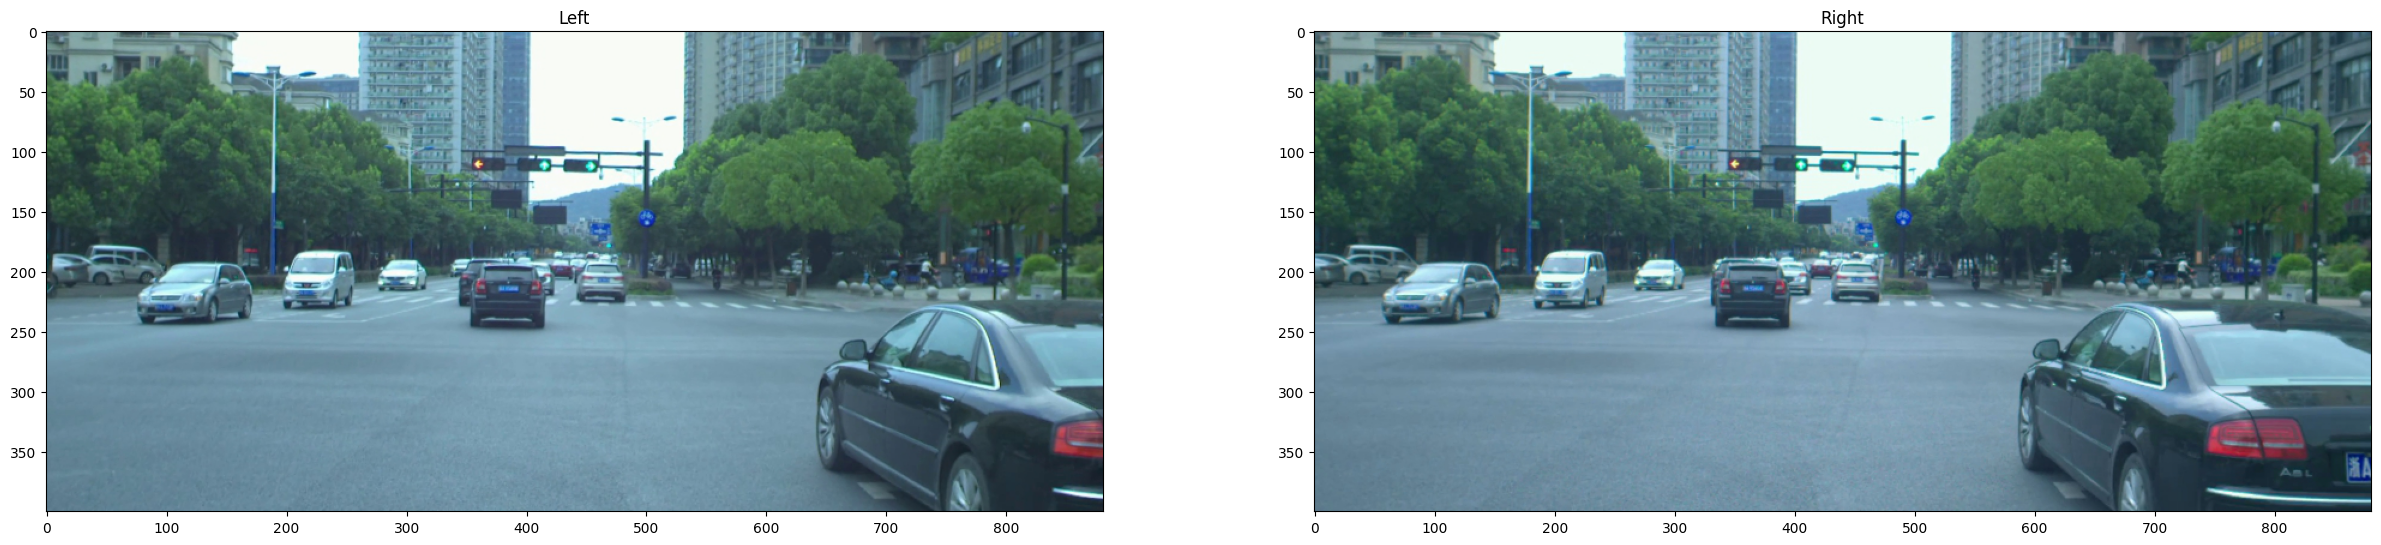

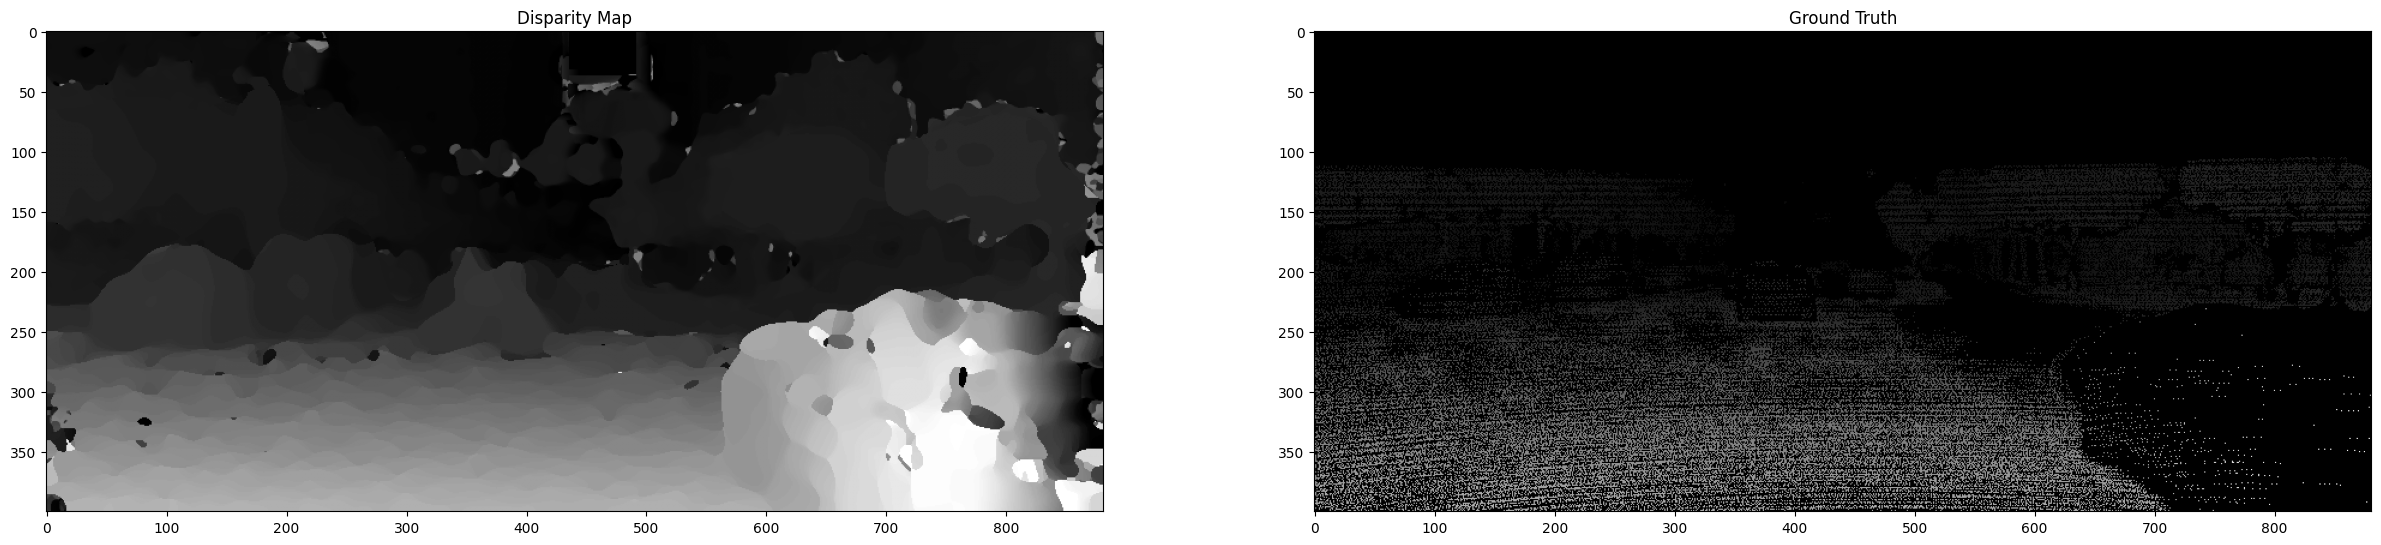

In [15]:
window = 7
i = 19
pipeline_disparity(left_images[i], right_images[i], ground_truths[i], window, M2)

由上面实验结果可知，当steps的值越来越大，步长越来越大时，噪点的存在就越来越少，
实验图片中的物体纹理愈发明显，但是会丧失许多细节，图片画面过于平滑。所以步长应取适中，以下实验取为20。

由上图的实验结果可以看到，当随着窗口大小不断增大时，可以看到视差图的噪点不断减少，
并且图片的细节也不断变少，实验图片中含有的具体细节都有被一定的平滑抹去掉，
但由于窗口增大后的边缘逐渐模糊，也更有利于我们判断物体边缘。所以可以显而易见地得出对于wid的取值，
我们应该要视情况而定，一般取适中即可，不可过大或过小。
并且，在匹配算法是我们追求的更多是对于位置特征的准确性，需要较多的细节，所以wid取值可以偏小，大约为10即可。